In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer    
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import KFold, cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier
!pip install category-encoders
from category_encoders import TargetEncoder
import lightgbm as lgb






In [2]:
df_train  = pd.read_csv(r"/kaggle/input/playground-series-s5e12/train.csv")
df_test = pd.read_csv(r'/kaggle/input/playground-series-s5e12/test.csv')
test = df_test.copy()

In [3]:
df_train.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [4]:
X = df_train.drop(columns=['diagnosed_diabetes', 'id'])
y = df_train['diagnosed_diabetes']

In [5]:
X.shape, y.shape

((700000, 24), (700000,))

In [6]:

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('hypertension_history')
numerical_cols.remove('cardiovascular_history')
numerical_cols.remove('family_history_diabetes')

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [7]:
print("Categorical Columns:", categorical_cols, len(categorical_cols))
print("Numerical Columns:", numerical_cols, len(numerical_cols))

Categorical Columns: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status'] 6
Numerical Columns: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides'] 15


In [8]:
for cols in categorical_cols:
    print(f"Value counts for {cols}:")
    print(X[cols].value_counts())
    print("\n")

Value counts for gender:
gender
Female    363237
Male      333085
Other       3678
Name: count, dtype: int64


Value counts for ethnicity:
ethnicity
White       386153
Hispanic    129984
Black       106301
Asian        60120
Other        17442
Name: count, dtype: int64


Value counts for education_level:
education_level
Highschool      344145
Graduate        261268
Postgraduate     79642
No formal        14945
Name: count, dtype: int64


Value counts for income_level:
income_level
Middle          290557
Lower-Middle    178570
Upper-Middle    127836
Low              85803
High             17234
Name: count, dtype: int64


Value counts for smoking_status:
smoking_status
Never      494448
Current    103363
Former     102189
Name: count, dtype: int64


Value counts for employment_status:
employment_status
Employed      516170
Retired       115735
Unemployed     49787
Student        18308
Name: count, dtype: int64




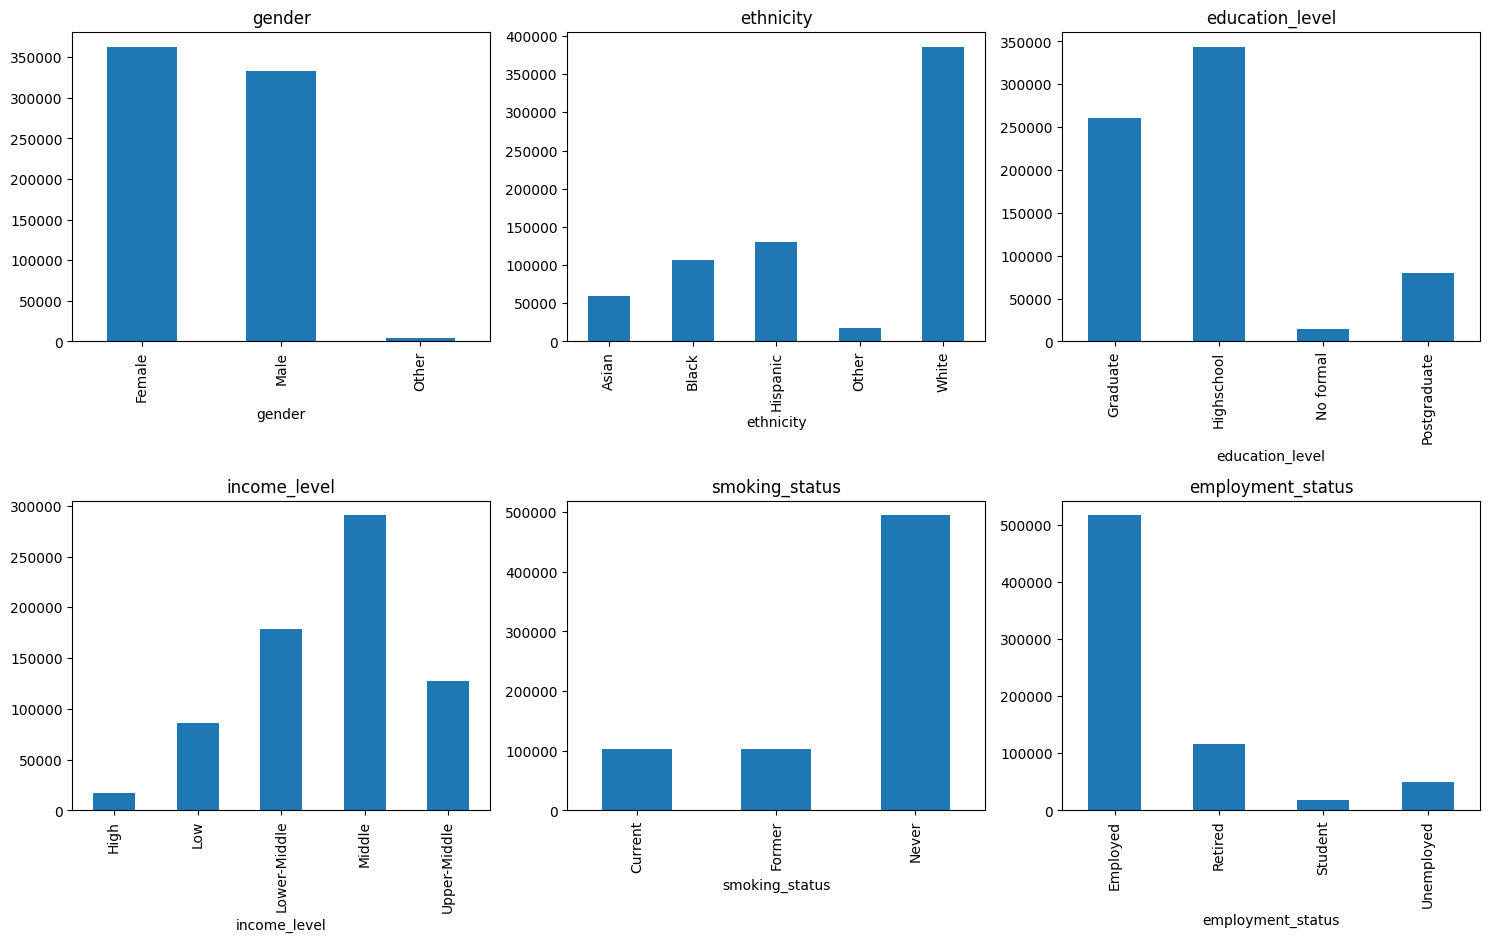

In [9]:
plt.figure(figsize=(15,13))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3,3, i)
    gen = X.groupby(col).size()
    gen.plot.bar(stacked=True)
    plt.title(col)
plt.tight_layout()
plt.show()

In [10]:
X.describe()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history
count,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000
mean,50.359734,2.072411,80.230803,5.963695,7.002200,6.012733,25.874684,0.858766,116.294193,75.440924,70.167749,186.818801,53.823214,102.905854,123.081850,0.149401,0.181990,0.030324
std,11.655520,1.048189,51.195071,1.463336,0.901907,2.022707,2.860705,0.037980,11.010390,6.825775,6.938722,16.730832,8.266545,19.022416,24.739397,0.356484,0.385837,0.171478
min,19.000000,1.000000,1.000000,0.100000,3.100000,0.600000,15.100000,0.680000,91.000000,51.000000,42.000000,117.000000,21.000000,51.000000,31.000000,0.000000,0.000000,0.000000
25%,42.000000,1.000000,49.000000,5.000000,6.400000,4.600000,23.900000,0.830000,108.000000,71.000000,65.000000,175.000000,48.000000,89.000000,106.000000,0.000000,0.000000,0.000000
50%,50.000000,2.000000,71.000000,6.000000,7.000000,6.000000,25.900000,0.860000,116.000000,75.000000,70.000000,187.000000,54.000000,103.000000,123.000000,0.000000,0.000000,0.000000
75%,58.000000,3.000000,96.000000,7.000000,7.600000,7.400000,27.800000,0.880000,124.000000,80.000000,75.000000,199.000000,59.000000,116.000000,139.000000,0.000000,0.000000,0.000000
max,89.000000,9.000000,747.000000,9.900000,9.900000,16.500000,38.400000,1.050000,163.000000,104.000000,101.000000,289.000000,90.000000,205.000000,290.000000,1.000000,1.000000,1.000000


In [11]:
print("CORRELATION WITH TARGET VARIABLE:\n")
correlations = df_train[numerical_cols + ['diagnosed_diabetes']].corr()['diagnosed_diabetes'].sort_values(ascending=False)
print(correlations)

CORRELATION WITH TARGET VARIABLE:

diagnosed_diabetes                    1.000000
age                                   0.161162
systolic_bp                           0.107132
bmi                                   0.105580
ldl_cholesterol                       0.102771
triglycerides                         0.090635
cholesterol_total                     0.088112
waist_to_hip_ratio                    0.081050
diastolic_bp                          0.036271
heart_rate                            0.023865
screen_time_hours_per_day             0.018213
sleep_hours_per_day                   0.003509
alcohol_consumption_per_week          0.002991
diet_score                           -0.050119
hdl_cholesterol                      -0.053231
physical_activity_minutes_per_week   -0.169789
Name: diagnosed_diabetes, dtype: float64


In [12]:
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Normal weight'
    elif 25 <= bmi < 29.9:
        return 'Overweight'
    else:
        return 'Obesity'
X['bmi_category'] = X['bmi'].apply(bmi_category)
df_test['bmi_category'] = df_test['bmi'].apply(bmi_category)

X['bmi_category'].value_counts()    

bmi_category
Overweight       378819
Normal weight    251102
Obesity           66973
Underweight        3106
Name: count, dtype: int64

In [13]:
df_test['medical_history_count'] = df_test[['cardiovascular_history', 'family_history_diabetes', 'hypertension_history']].sum(axis=1)
X['medical_history_count'] = X[['cardiovascular_history', 'family_history_diabetes', 'hypertension_history']].sum(axis=1)


In [14]:
X['ldl_hdl_ratio'] = X['ldl_cholesterol'] / (X['hdl_cholesterol']+1)
df_test['ldl_hdl_ratio'] = df_test['ldl_cholesterol'] / (df_test['hdl_cholesterol']+1)

In [15]:
X['cholesterol_ratio'] = X['cholesterol_total'] / (X['hdl_cholesterol']+1)
df_test['cholesterol_ratio'] = df_test['cholesterol_total'] / (df_test['hdl_cholesterol']+1)

In [16]:
  df_test['Hypertension_Risk'] = ((df_test['systolic_bp'] >= 130) | (df_test['diastolic_bp'] >= 80)).astype(int)
  X['Hypertension_Risk'] = ((X['systolic_bp'] >= 130) | (X['diastolic_bp'] >= 80)).astype(int)

In [17]:
X["age_bmi"] = X["age"] * X["bmi"]
df_test["age_bmi"] = df_test["age"] * df_test["bmi"]

In [18]:
numerical_cols =    X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('hypertension_history')
numerical_cols.remove('cardiovascular_history')
numerical_cols.remove('family_history_diabetes')
numerical_cols.remove('medical_history_count')
numerical_cols.remove('Hypertension_Risk')


categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [19]:
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
imp = SimpleImputer(strategy="median")

X[categorical_cols] = enc.fit_transform(X[categorical_cols])
df_test[categorical_cols] = enc.transform(df_test[categorical_cols])

X[numerical_cols] = imp.fit_transform(X[numerical_cols])
df_test[numerical_cols] = imp.transform(df_test[numerical_cols])

In [20]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(X))
pred_lgb = np.zeros(len(df_test))

In [21]:
df_test = df_test.drop(columns=['id'])

In [22]:
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== FOLD {fold+1} / 5 =====")

    X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    
    model = LGBMClassifier(
        n_estimators=1500,
        learning_rate= 0.15550266487959966,
        num_leaves= 215,
        max_depth= 3,
        min_child_samples= 73,
        subsample= 0.9082199990178259,
        colsample_bytree= 0.621473703438141,
        reg_alpha= 3.679996794053407,
        reg_lambda= 7.731770344772727,
        random_state= 42,
        verbosity=-1
    )
    model.fit(X_train, y_train,
           eval_set=[(X_valid, y_valid)], 
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=0) 
        ])

    oof_lgb[val_idx] = model.predict_proba(X_valid)[:, 1]
    pred_lgb += model.predict_proba(df_test)[:, 1] / kf.n_splits



===== FOLD 1 / 5 =====

===== FOLD 2 / 5 =====

===== FOLD 3 / 5 =====

===== FOLD 4 / 5 =====

===== FOLD 5 / 5 =====


In [23]:
print("\nLightGBM ROC:", roc_auc_score(y, oof_lgb))


LightGBM ROC: 0.729031597963563


In [24]:
submission_data = pd.DataFrame({
        "id": test['id'],
        "diagnosed_diabetes": pred_lgb
})
submission_data.to_csv('submission.csv', index = False)